# Depth Estimation

In [21]:
# importing the libraries
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Stereo Based Depth Estimation

It is a local method algorithm used in depth estimation. It is fast but works on less complex images.

(3000, 3976) (3000, 3976)


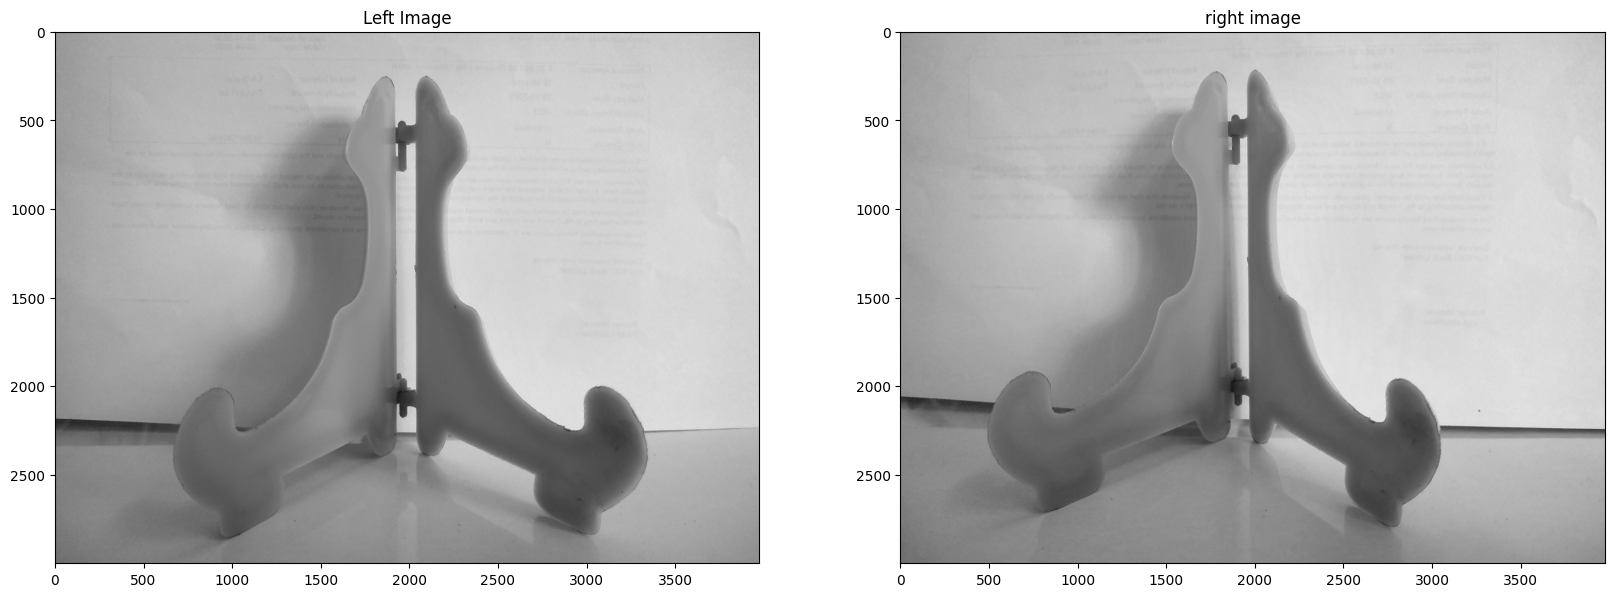

In [7]:
# reading the images
left_image_gray = cv2.imread('left_image.jpg',cv2.IMREAD_GRAYSCALE)
right_image_gray = cv2.imread('right_image.png',cv2.IMREAD_GRAYSCALE)
right_image_gray = right_image_gray[:,:3976]

plt.figure(figsize=(20,10))
plt.subplot(121); plt.imshow(left_image_gray,cmap='gray'); plt.title('Left Image')
plt.subplot(122); plt.imshow(right_image_gray,cmap='gray'); plt.title('right image')
print(left_image_gray.shape,right_image_gray.shape)

In [9]:
?cv2.StereoBM_create

Docstring:
StereoBM_create([, numDisparities[, blockSize]]) -> retval
.   @brief Creates StereoBM object
.   
.       @param numDisparities the disparity search range. For each pixel algorithm will find the best
.       disparity from 0 (default minimum disparity) to numDisparities. The search range can then be
.       shifted by changing the minimum disparity.
.       @param blockSize the linear size of the blocks compared by the algorithm. The size should be odd
.       (as the block is centered at the current pixel). Larger block size implies smoother, though less
.       accurate disparity map. Smaller block size gives more detailed disparity map, but there is higher
.       chance for algorithm to find a wrong correspondence.
.   
.       The function create StereoBM object. You can then call StereoBM::compute() to compute disparity for
.       a specific stereo pair.
Type:      builtin_function_or_method

In [8]:
# computing disparity
stereo = cv2.StereoBM_create(numDisparities=16*16,blockSize=15)
disparity = stereo.compute(left_image_gray,right_image_gray)

In [13]:
?stereo.compute

Docstring:
compute(left, right[, disparity]) -> disparity
.   @brief Computes disparity map for the specified stereo pair
.   
.       @param left Left 8-bit single-channel image.
.       @param right Right image of the same size and the same type as the left one.
.       @param disparity Output disparity map. It has the same size as the input images. Some algorithms,
.       like StereoBM or StereoSGBM compute 16-bit fixed-point disparity map (where each disparity value
.       has 4 fractional bits), whereas other algorithms output 32-bit floating-point disparity map.
Type:      builtin_function_or_method

In [33]:
?cv2.normalize

Docstring:
normalize(src, dst[, alpha[, beta[, norm_type[, dtype[, mask]]]]]) -> dst
.   @brief Normalizes the norm or value range of an array.
.   
.   The function cv::normalize normalizes scale and shift the input array elements so that
.   \f[\| \texttt{dst} \| _{L_p}= \texttt{alpha}\f]
.   (where p=Inf, 1 or 2) when normType=NORM_INF, NORM_L1, or NORM_L2, respectively; or so that
.   \f[\min _I  \texttt{dst} (I)= \texttt{alpha} , \, \, \max _I  \texttt{dst} (I)= \texttt{beta}\f]
.   
.   when normType=NORM_MINMAX (for dense arrays only). The optional mask specifies a sub-array to be
.   normalized. This means that the norm or min-n-max are calculated over the sub-array, and then this
.   sub-array is modified to be normalized. If you want to only use the mask to calculate the norm or
.   min-max but modify the whole array, you can use norm and Mat::convertTo.
.   
.   In case of sparse matrices, only the non-zero values are analyzed and transformed. Because of this,
.   the range 

In [14]:
# normalize the disparity 
normalized_disparity = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

Text(0.5, 1.0, 'Disparity map')

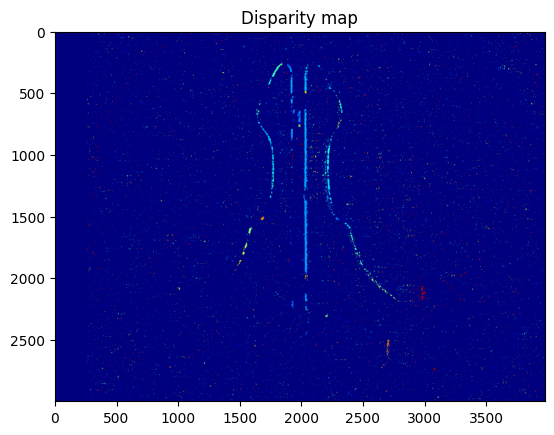

In [15]:
# display disparity 
plt.imshow(normalized_disparity,cmap='jet')
plt.title('Disparity map')

Text(0.5, 1.0, 'Depth Map')

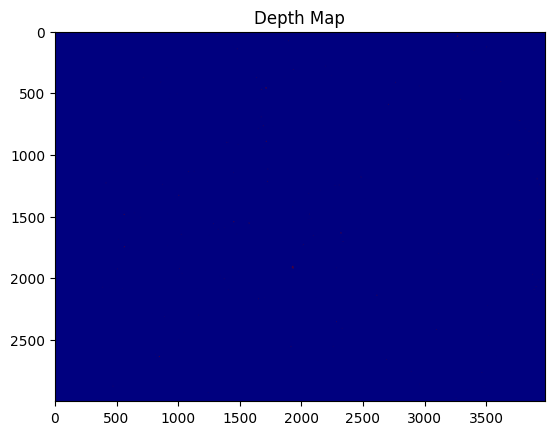

In [18]:
disparity_safe = disparity.astype(float) + 1e-5
depth_map = 1 / disparity_safe
depth_map_normalized = cv2.normalize(depth_map,None,alpha = 0,beta=255,norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_8U)

plt.imshow(depth_map_normalized,cmap='jet')
plt.title('Depth Map')

# Monocular Depth Estimation

As the name says, this method only needs a single image. In this we use pretrained deep learning neural network called MiDaS (Monocular Depth estimation using Deep Learning).  

In [23]:
# load the model 
model_type = 'MiDaS_small'
midas = torch.hub.load('intel-isl/MiDaS',model_type)

Using cache found in C:\Users\jaisu/.cache\torch\hub\intel-isl_MiDaS_master
C:\Users\jaisu\DevMode\git\learning-cv\.venv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loading weights:  None


C:\Users\jaisu\DevMode\git\learning-cv\.venv\Lib\site-packages\torch\hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to C:\Users\jaisu/.cache\torch\hub\master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to C:\Users\jaisu/.cache\torch\hub\checkpoints\tf_efficientnet_lite3-b

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device)
midas.eval()

MidasNet_small(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2dSameExport(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU6(inplace=True)
          (se): Identity()
          (conv_pw): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
        )
      )
      (4): Sequential(
        (0): InvertedResidual(
          (conv_pw): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(144,

In [25]:
midas_transforms = torch.hub.load("intel-isl/MiDaS","transforms")
transform = midas_transforms.small_transform

Using cache found in C:\Users\jaisu/.cache\torch\hub\intel-isl_MiDaS_master


In [27]:
# load the image
image_bgr = cv2.imread('mountain.jpg')
image_rgb = cv2.cvtColor(image_bgr,cv2.COLOR_BGR2RGB)

input_batch = transform(image_rgb).to(device)

Text(0.5, 1.0, 'Input Image')

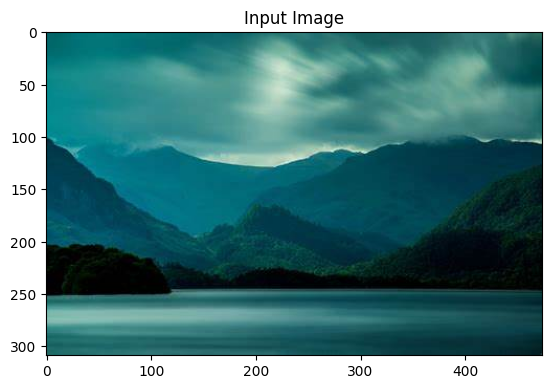

In [31]:
plt.imshow(image_rgb)
plt.title('Input Image')

In [34]:
?torch.nn.functional.interpolate

Signature:
torch.nn.functional.interpolate(
    input: torch.Tensor,
    size: Optional[int] = None,
    scale_factor: Optional[List[float]] = None,
    mode: str = 'nearest',
    align_corners: Optional[bool] = None,
    recompute_scale_factor: Optional[bool] = None,
    antialias: bool = False,
) -> torch.Tensor
Docstring:
Down/up samples the input.

Tensor interpolated to either the given :attr:`size` or the given
:attr:`scale_factor`

The algorithm used for interpolation is determined by :attr:`mode`.

Currently temporal, spatial and volumetric sampling are supported, i.e.
expected inputs are 3-D, 4-D or 5-D in shape.

The input dimensions are interpreted in the form:
`mini-batch x channels x [optional depth] x [optional height] x width`.

The modes available for resizing are: `nearest`, `linear` (3D-only),
`bilinear`, `bicubic` (4D-only), `trilinear` (5D-only), `area`, `nearest-exact`

Args:
    input (Tensor): the input tensor
    size (int or Tuple[int] or Tuple[int, int] or Tup

In [29]:
# predicting the depth
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size = image_rgb.shape[:2],
        mode = "bicubic",
        align_corners = False,
    ).squeeze()

depth_map = prediction.cpu().numpy()

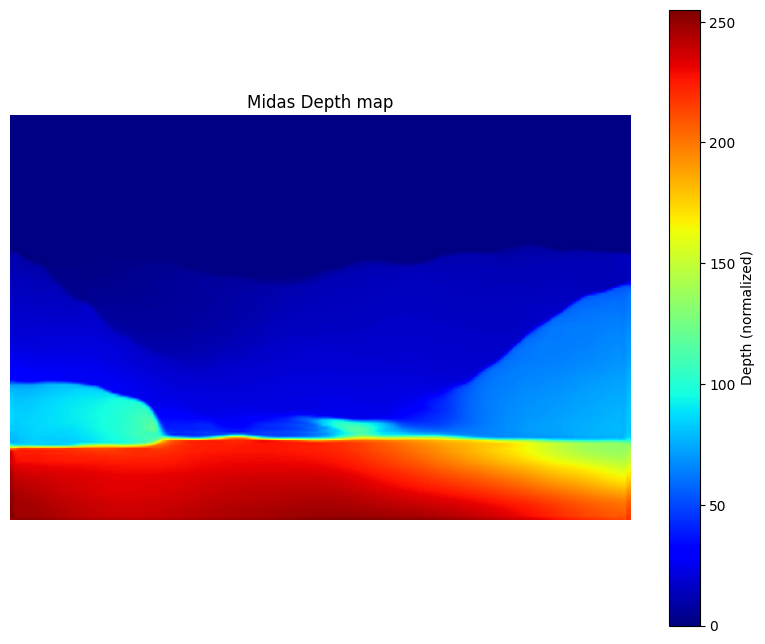

In [30]:
depth_map_normalized = cv2.normalize(depth_map,None,0,255,cv2.NORM_MINMAX,dtype=cv2.CV_8U)
plt.figure(figsize=(10,8))
plt.title('Midas Depth map')
plt.imshow(depth_map_normalized,cmap='jet')
plt.colorbar(label='Depth (normalized)')
plt.axis('off')
plt.show()

In [32]:
# saving the result
cv2.imwrite('depth_map_normalized_midas_mountain.png',depth_map_normalized)
print('saved')

saved
